## Twitter API

In [39]:
from TwitterAPI import TwitterAPI

import hashlib
import getpass

import pandas as pd

COMPUTER_USERNAME_HASH = "327529c973f4a2eca02eda86530afdacbcb2d04af59de078201a6c1d3e1f7af2"

In [10]:
### Input a file path to my credentials ###
# No peeking! Did you think I would put my computer's username in the code?
computer_username = getpass.getpass("Type in a computer username: ")
hashGen = hashlib.sha256()
hashGen.update(computer_username.encode('utf-8'))
if COMPUTER_USERNAME_HASH != hashGen.hexdigest(): 
    raise ValueError("Incorrect file path passed to code!")

Type in a computer username: ········


In [11]:
### Access Twitter credentials at the given file ###
twitter_credentials_fpath = f"/Users/{computer_username}/Documents/TWITTER_API_CREDENTIALS.txt"
twitter_credentials_file = open(twitter_credentials_fpath, 'r')
twitter_credentials = twitter_credentials_file.read().split("\n")

In [12]:
### Input a file path to my Reddit credentials ###
TWITTER_APP_KEY = twitter_credentials[0]
TWITTER_APP_KEY_SECRET = twitter_credentials[1]
TWITTER_ACCESS_TOKEN = twitter_credentials[2]
TWITTER_ACCESS_TOKEN_SECRET = twitter_credentials[3]

In [52]:
MAX_TWEETS = 100

api = TwitterAPI(TWITTER_APP_KEY, 
               TWITTER_APP_KEY_SECRET, 
               TWITTER_ACCESS_TOKEN, 
               TWITTER_ACCESS_TOKEN_SECRET)

queries = ['#darkpattern', '#darkpatterns', '@darkpatterns']
counts = [MAX_TWEETS] * 3

MAIN_URL = "https://t.co/"

keynames = ['Created at: ', 'ID String: ', 'Text: ', 'Is_Truncated: ']
keys = ['created_at', 'idstr', 'text', 'truncated']
keynames_meta = ['Language: ', 'Result_Type: ']
keys_meta = ['iso_language_code', 'result_type']

data_rowslist = []

In [54]:
#### WARNING: DO NOT RUN UNLESS YOU REALLY WANT TO !!! ####
mainpath = f"/Users/{computer_username}/Desktop/"
outfile = open(mainpath + "TWITTER_DATA_partial.txt", "a")
# Sweeps through several requests at once
for query, cnt in zip(queries, counts):
    req = api.request('search/tweets', {'q': query, 'count': cnt})
    # Sweeps through all tweets in a request
    for item in req:  
        results = {k: '' for k in keys + keys_meta}
        for name, k in zip(keynames, keys): 
            if k in item: 
                entry = str(item[k])
                entry = entry.replace('\n', '')
                entry = entry.replace('\t', '')
                results[k] = entry
        for name, k in zip(keynames_meta, keys_meta):
            if 'metadata' in item and k in item['metadata']: results[k] = item['metadata'][k]
        # Add URL to the data
        url = ''
        if 'text' in item: 
            url_idx = item['text'].rfind(MAIN_URL)
            url = item['text'][url_idx:]
        results['url'] = url
        data_rowslist.append(results)
        rowlist = [str(val) for val in results.values()]
        outfile.write('\t'.join(rowlist) + '\n')

    print(f"\nQUOTA: {req.get_quota()}")


QUOTA: {'remaining': 162, 'limit': None, 'reset': None}

QUOTA: {'remaining': 161, 'limit': None, 'reset': None}

QUOTA: {'remaining': 160, 'limit': None, 'reset': None}


In [55]:
### Save and print the data ###
outfile.close()
column_list = keys + keys_meta + ['url']
data = pd.DataFrame(data_rowslist, columns=column_list)
# print(data)
data.to_csv(mainpath + "TWITTER_DATA.txt", sep='\t', index=False)

Link to Twitter API guide: https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets

Link to StackOverflow for Twitter API: https://stackoverflow.com/questions/14156625/fetching-tweets-with-hashtag-from-twitter-using-python

## Reddit API

In [32]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

dirpath = "/Users/openamiguel/Documents/REDDIT/CODING_00/"
os.chdir(dirpath)
df = pd.read_csv("CODING_00_DATA.txt", sep='\t')
columns = ["ID", "Title_Artifacts", "Title_Code", "Is_Asshole_Design", "Modality_Code", "Interaction_Domain_Code", "Interaction_Purpose_Code", "Is_Dark_Pattern", "Dark_Pattern_Code"]
df.columns = columns

# Filter out posts that are not asshole design
df_filtered = df[df.Is_Asshole_Design == "Y;Y;Y"]
# Filter out posts that are not dark patterns
df_filtered = df_filtered[df_filtered.Is_Dark_Pattern == "Y"]
print(df_filtered.head())
print()
print(f"Length of dataframe: {len(df_filtered)}")

       ID                                    Title_Artifacts Title_Code  \
0  b0qpuz                                     Black very low       EC;S   
1  b9az02               Enriched with Vitamin A;Vitamin A 0%          U   
2  b9uuf8  EVICTION NOTICE: We regret to inform you that ...         EC   
3  bam9n9   Are you sure you want to cancel a free download?          F   
5  bzrz6k  3 FREE months of Uconnect Access. Press the Ca...          U   

  Is_Asshole_Design Modality_Code Interaction_Domain_Code  \
0             Y;Y;Y             O                      PP   
1             Y;Y;Y             P                      PP   
2             Y;Y;Y             P                       C   
3             Y;Y;Y             C                      PS   
5             Y;Y;Y             O                      PP   

  Interaction_Purpose_Code Is_Dark_Pattern Dark_Pattern_Code  
0                       IN               Y                HI  
1                       PA               Y              

In [54]:
# Subsumes certain codes with a broader category
# Relevant to dark patterns only
def get_code_replace(): 
    code_replace = dict()
    replace_1 = ['RM', 'PC', 'IC'] # Replace with 'O'
    replace_2 = ['FC', 'HC', 'SB', 'BAS'] # Replace with 'S'
    replace_3 = ['HI', 'PS', 'AM', 'TE', 'FH', 'DA', 'TQ'] # Replace with 'II'
    replace_4 = ['SP', 'PZ', 'G'] # Replace with 'FA'
    replaces = ['O', 'S', 'II', 'FA']
    replace_list = [replace_1, replace_2, replace_3, replace_4]

    for newcode, oldlist in zip(replaces, replace_list): 
        for entry in oldlist: 
            code_replace[entry] = newcode
    
    return code_replace

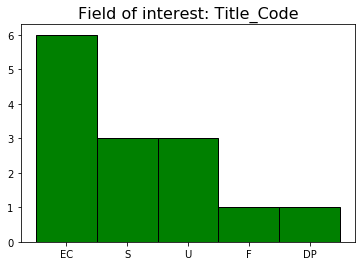

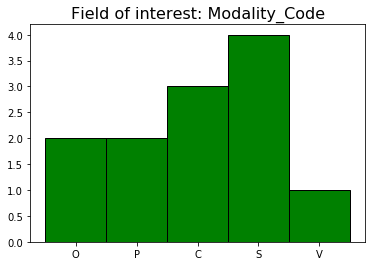

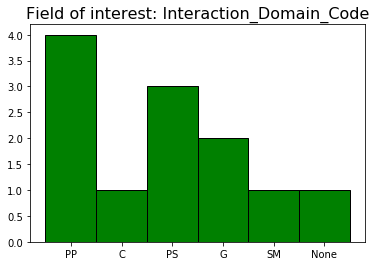

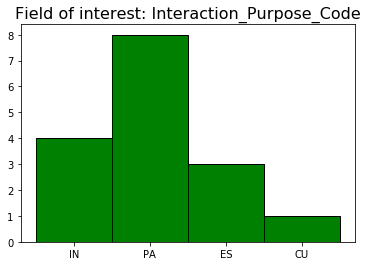

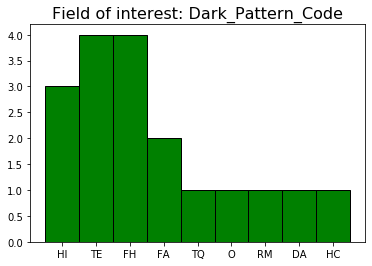

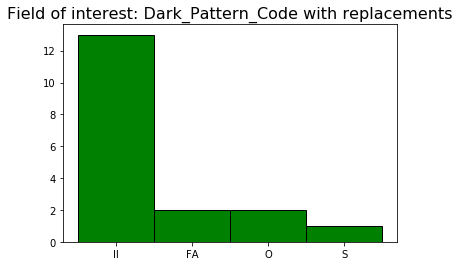

({'II': 13, 'FA': 2, 'O': 2, 'S': 1}, 18)

In [58]:
# Plot all codes under one header
def plot_codes(field_of_interest: str, code_replace: dict={}): 
    codes = dict()
    for row in df_filtered[field_of_interest]: 
        entries = row.split(';')
        for entry in entries: 
            entry_rep = entry
            if entry_rep in code_replace.keys(): 
                entry_rep = code_replace[entry_rep]
            if entry_rep in codes.keys(): 
                codes[entry_rep] = codes[entry_rep] + 1
            else:
                codes[entry_rep] = 1
    title = f"Field of interest: {field_of_interest}"
    if len(code_replace.keys()) > 0: title = title + " with replacements"
    plt.title(title, fontsize=16)
    plt.bar(codes.keys(), codes.values(), width=1, color='g', edgecolor='k')
    plt.show()
    
    return codes, np.sum(np.array(list(codes.values())))

for colname in columns:
    if "Code" in colname: plot_codes(colname)

plot_codes("Dark_Pattern_Code", code_replace=get_code_replace())

In [60]:
import pandas as pd
import glob, os
from random import sample
import shutil

dirpath = "/Users/openamiguel/Documents/REDDIT/"
os.chdir(dirpath)
df = pd.read_csv("DATA_0401.txt", sep='\t')
# print(df.head())
# Save a certain number of images to a special folder
num_files = 20
analysis_num = 1
indices = [i for i in range(len(df))]
sampled_indices = sample(indices, len(df))

i = 0
j = 0
while i < num_files: 
    idx = sampled_indices[j]
    j = j + 1
    file_id = df.loc[idx, 'ID']
    sourcelist = glob.glob(file_id + ".*")
    if len(sourcelist) == 0: continue
    print(file_id)
    source = sourcelist[0]
    target = f"{dirpath}CODING_{analysis_num:02d}/" + source
    try: shutil.copyfile(source, target)
    except IOError as e:
        print(f"Unable to copy file. {e:s}")
        exit(1)
    except: 
        print(f"Unexpected error: {sys.exc_info()}")
        exit(1)
    i = i + 1

print(f"Total number of files: {i}")

bhzw6v


TypeError: unsupported format string passed to FileNotFoundError.__format__

In [3]:
#! usr/bin/env python3
import praw
import urllib.request

import pandas as pd

from datetime import datetime
import time
import os.path

import pprint

from textblob import TextBlob

DELAY = 0.5

In [9]:
### Access Reddit credentials at the given file ###
reddit_credentials_fpath = f"/Users/{computer_username}/Documents/REDDIT_API_CREDENTIALS.txt"
reddit_credentials_file = open(reddit_credentials_fpath, 'r')
reddit_credentials = reddit_credentials_file.read().split("\n")

In [10]:
### Access credentials from file on same machine ###
REDDIT_PERSONAL_USE_SCRIPT = reddit_credentials[0]
REDDIT_SECRET_KEY = reddit_credentials[1]
REDDIT_APP_NAME = reddit_credentials[2]
# No peeking! Did you think I would put my Reddit password in the code? 
# Username & password are unnecessary for public posts
REDDIT_USER_NAME = reddit_credentials[3]
REDDIT_LOGIN_PASSWORD = reddit_credentials[4]

In [11]:
### Plug credentials into a parser object ###
reddit = praw.Reddit(client_id=REDDIT_PERSONAL_USE_SCRIPT, \
                     client_secret=REDDIT_SECRET_KEY, \
                     user_agent=REDDIT_APP_NAME, \
                     username=REDDIT_USER_NAME, \
                     password=REDDIT_LOGIN_PASSWORD)

In [ ]:
# assume you have a Reddit instance bound to variable `reddit`
submission = reddit.submission(id='39zje0')
print(submission.title) # to make it non-lazy
pprint.pprint(vars(submission))

In [13]:
### Compute date & time from Unix timestamp ###
def get_time_from_unix(timestamp: int): 
    return datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

In [14]:
### Defines the permissible flairs ###
ALLOWED_FLAIRS = [None, "Bad Unsubscribe Function", "Clickshaming", "Dark Pattern", \
                  "Bait and Switch", "Loaded Question"]
IMAGE_TAGS = ["i.redd.it", ".png", ".jpg", ".gif"]
VIDEO_TAGS = ["v.redd.it", ".mp4", ".mov"]

In [17]:
### Defines parsing parameters for a designated subreddit ###
subreddit = reddit.subreddit('assholedesign')
# Options: all, year, day, hour, week, month
top_subreddit = subreddit.top('day', limit=1000)
mainpath = f"/Users/{computer_username}/Desktop/Reddit/"

data_rowslist = []
column_list = ["ID", "Title", "Title_Language", "Media_Type", "Media_URL", "Date_Time", "Flair", \
               "Local_File_Name", "Is_OC", "Score", "Upvote_Ratio"]


### Parses a designated subreddit for certain data ###
outfile = open(mainpath + "DATA_partial.txt", "a")
for submission in top_subreddit: 
    # Removes all posts without URLs (i.e. posts without images)
    if submission.is_self: continue
    # Removes all posts without the proper flairs
    if submission.link_flair_text not in ALLOWED_FLAIRS: continue
    # Removes all posts with low score (might not be "asshole design")
    if submission.upvote_ratio < 0.6: continue
    # Determines if the title is English
    title_obj = TextBlob(submission.title)
    title_lang = title_obj.detect_language()
    # if title_lang != "en": continue
    # Parses date & time
    submission_datetime = get_time_from_unix(int(float(submission.created_utc)))
    # Decides if media is image or video
    submission_type = "Other"
    submission_url = submission.url
    if any([img_tag in submission_url for img_tag in IMAGE_TAGS]): submission_type = "Image"
    elif any([vid_tag in submission_url for vid_tag in VIDEO_TAGS]): submission_type = "Video"
    elif "imgur.com" in submission_url: submission_type = "Imgur_Non_Image"
    # Gives the media a location on my computer
    submission_localname = mainpath + submission.id + "." + submission_url.split('.')[-1]
    # Retrieves images ONLY
    if submission_type == "Image" and not os.path.isfile(submission_localname): 
        urllib.request.urlretrieve(submission_url, submission_localname)
    else: submission_localname = "NA"
    # Saves all the data
    rowdict = {}
    rowdict["ID"] = submission.id
    rowdict["Title"] = submission.title.replace('\t', '')
    rowdict["Title Language"] = title_lang
    rowdict["Media_Type"] = submission_type
    rowdict["Media_URL"] = submission_url
    rowdict["Date_Time"] = submission_datetime
    flair = submission.link_flair_text
    if flair != None: flair = flair.replace('\t', '')
    rowdict["Flair"] = flair
    rowdict["Local_File_Name"] = '/'.join(submission_localname.split('/')[3:])
    rowdict["Is_OC"] = submission.is_original_content
    rowdict["Score"] = submission.score
    rowdict["Upvote_Ratio"] = submission.upvote_ratio
    # Collects data in Pandas DataFrame
    data_rowslist.append(rowdict)
    rowlist = [str(val) for val in rowdict.values()]
    outfile.write('\t'.join(rowlist) + '\n')
    
    print(f"Current ID: {submission.id}")
    # print(submission.title)
    # time.sleep(DELAY)

outfile.close()

Current ID: fs8pcf
Current ID: fske7v
Current ID: fsdf3o
Current ID: fs7nac
Current ID: fsesis
Current ID: fs2if8
Current ID: fsfm2z
Current ID: fs8g9o
Current ID: fslh2b


In [40]:
### Save and print the data ###
data = pd.DataFrame(data_rowslist, columns=column_list)
# print(data)
data.to_csv(mainpath + "DATA.txt", sep='\t', index=False)

## MySQL Database API

In [31]:
### Access credentials at the given file ###
mysql_credentials_fpath = f"/Users/{computer_username}/Documents/REDDIT_API_CREDENTIALS.txt"
mysql_credentials_file = open(mysql_credentials_fpath, 'r')
MYSQL_PASSWORD = mysql_credentials_file.read().split("\n")[0]

In [32]:
import pymysql.cursors
import pymysql

# Connect to the database
connection = pymysql.connect(host='localhost',
                             user='user',
                             password=MYSQL_PASSWORD,
                             db='db',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

try:
    with connection.cursor() as cursor:
        # Create a new record
        sql = "INSERT INTO `users` (`email`, `password`) VALUES (%s, %s)"
        cursor.execute(sql, ('webmaster@python.org', 'very-secret'))

    # connection is not autocommit by default. So you must commit to save
    # your changes.
    connection.commit()

    with connection.cursor() as cursor:
        # Read a single record
        sql = "SELECT `id`, `password` FROM `users` WHERE `email`=%s"
        cursor.execute(sql, ('webmaster@python.org',))
        result = cursor.fetchone()
        print(result)
finally:
    connection.close()

OperationalError: (1045, "Access denied for user 'user'@'localhost' (using password: YES)")

Link to Guide: https://www.storybench.org/how-to-scrape-reddit-with-python/